In [48]:
import numpy as np
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from parse_filenames import parse_filenames, tryconvert
from scipy import stats
import pickle

In [49]:
os.path.exists(Path.home() / 'Desktop' / 'data2' / 'delta_amplitude_dict.pkl')

False

In [50]:
if os.path.exists(Path.home() / 'Desktop' / 'disk2' / 'delta_amplitude_dict.pkl'):
    with open(Path.home() / 'Desktop' / 'disk2' / 'delta_amplitude_dict.pkl', 'rb') as f: delta_amplitude_dict = pickle.load(f)
else: delta_amplitude_dict = {}

def write_to_delta_amplitude_dict(value, upper_key, lower_key=None):
    if not lower_key:
        delta_amplitude_dict[upper_key] = value
    else:
        if upper_key not in delta_amplitude_dict.keys(): delta_amplitude_dict[upper_key] = {}
        delta_amplitude_dict[upper_key][lower_key] = value

# -1-0 seconds & 1-2 seconds LFP power spectra

In [51]:
# LOAD = False # the dataframe with computed stats
# path = Path.home() / 'Desktop' / 'disk2' / 'lfp_power_spectra_dump_-1-0_1-2'
# df_filename = 'lfp_ps_parsed_df_-1-0_1-2.pkl'
# weights_column_name = 'flashesAveragedOver'
# legend = ['-1s-0s before flash','1s-2s after flash']
# img_save_filename = 'grand_average_lfp_power_spectra_-1-0_1-2.png'
# suptitle = "LFP power spectra during flashes -1-0s & 1-2s"
# ylims = [-1.3*10**-9, 3*10**-9]
# # ylims = None

# 0-1 seconds & -1-2 seoncds LFP power spectra

In [65]:
LOAD = False # the dataframe with computed stats
path = Path.home() / 'Desktop' / 'disk2' / 'lfp_power_spectra_dump_0-1_-1-2'
df_filename = 'lfp_ps_parsed_df_0-1_-1-2.pkl'
weights_column_name = 'flashesAveragedOver'
legend = ['0s-1s','-1s-2s']
img_save_filename = 'grand_average_lfp_power_spectra_0-1_-1-2.png'
suptitle = "LFP power spectra during flashes 0-1s & -1-2s"
ylims = [-2.5*10**-9, 1.4*10**-8]
# ylims = None

In [66]:
parsed_df = parse_filenames(path)
parsed_df

,sessionID,area,condition,running,flashesAveragedOver,micronsElectrodeDepth,filename
0,794812542,VISpm,toWhite,True,2,992.0,sessionID_794812542_area_VISpm_condition_toWhi...
1,742951821,VISp,toWhite,True,2,NaN,sessionID_742951821_area_VISp_condition_toWhit...
2,771990200,VISp,toBlack,True,14,1039.0,sessionID_771990200_area_VISp_condition_toBlac...
3,771990200,VISpm,toWhite,False,63,985.0,sessionID_771990200_area_VISpm_condition_toWhi...
4,742951821,VISpm,toBlack,True,1,NaN,sessionID_742951821_area_VISpm_condition_toBla...
...,...,...,...,...,...,...,...
144,715093703,VISp,toWhite,False,14,NaN,sessionID_715093703_area_VISp_condition_toWhit...
145,771160300,VISp,toWhite,True,29,1135.0,sessionID_771160300_area_VISp_condition_toWhit...
146,719161530,VISp,toWhite,False,17,762.0,sessionID_719161530_area_VISp_condition_toWhit...
147,761418226,VISpm,toBlack,False,74,1165.0,sessionID_761418226_area_VISpm_condition_toBla...


In [67]:
# Deleting rows without 8 conditions

for sid in parsed_df.sessionID.unique():
    if len(parsed_df[parsed_df.sessionID==sid]) != 8:
        parsed_df = parsed_df.drop(parsed_df[parsed_df.sessionID==sid].index)

In [68]:
conditions = [('VISpm', 'toWhite', True), ('VISpm', 'toBlack', True), ('VISpm', 'toWhite', False), ('VISpm', 'toBlack', False),
             ('VISp', 'toWhite', True), ('VISp', 'toBlack', True), ('VISp', 'toWhite', False), ('VISp', 'toBlack', False)]

for condition in conditions:
    selected_df = parsed_df[(parsed_df.area==condition[0]) & (parsed_df.condition==condition[1]) & (parsed_df.running==condition[2])]
    print(condition, len(selected_df))

('VISpm', 'toWhite', True) 18
('VISpm', 'toBlack', True) 18
('VISpm', 'toWhite', False) 18
('VISpm', 'toBlack', False) 18
('VISp', 'toWhite', True) 18
('VISp', 'toBlack', True) 18
('VISp', 'toWhite', False) 18
('VISp', 'toBlack', False) 18


In [69]:
parsed_df

,sessionID,area,condition,running,flashesAveragedOver,micronsElectrodeDepth,filename
1,742951821,VISp,toWhite,True,2,NaN,sessionID_742951821_area_VISp_condition_toWhit...
2,771990200,VISp,toBlack,True,14,1039.0,sessionID_771990200_area_VISp_condition_toBlac...
3,771990200,VISpm,toWhite,False,63,985.0,sessionID_771990200_area_VISpm_condition_toWhi...
4,742951821,VISpm,toBlack,True,1,NaN,sessionID_742951821_area_VISpm_condition_toBla...
5,791319847,VISpm,toWhite,True,19,1047.0,sessionID_791319847_area_VISpm_condition_toWhi...
...,...,...,...,...,...,...,...
144,715093703,VISp,toWhite,False,14,NaN,sessionID_715093703_area_VISp_condition_toWhit...
145,771160300,VISp,toWhite,True,29,1135.0,sessionID_771160300_area_VISp_condition_toWhit...
146,719161530,VISp,toWhite,False,17,762.0,sessionID_719161530_area_VISp_condition_toWhit...
147,761418226,VISpm,toBlack,False,74,1165.0,sessionID_761418226_area_VISpm_condition_toBla...


## Session averages

In [70]:
def get_iqr(data):
    iqrs = []

    for t in range(data.shape[1]):
        iqr = stats.iqr(data[:,t])
        iqrs.append(iqr)
        
    return np.array(iqrs)

In [71]:
parsed_df['f'] = ''
parsed_df['before_median'] = ''
parsed_df['before_iqr'] = ''
parsed_df['after_median'] = ''
parsed_df['after_iqr'] = ''

In [72]:
if LOAD:
    # Load the df
    with open(Path.home() / 'Desktop' / 'disk2' / df_filename, 'rb') as f: parsed_df = pickle.load(f)
else:
    for condition in conditions:
        selected_df = parsed_df[(parsed_df.area==condition[0]) & (parsed_df.condition==condition[1]) & (parsed_df.running==condition[2])]
        for cols in selected_df.iterrows():
            f, s1, s2 = np.load(path / cols[1].filename, allow_pickle=True)
            # Saving time data, median time series and iqr (variability measure) time series for eahc condition-session entry
            parsed_df.at[cols[0], 'f'] = f
            parsed_df.at[cols[0], 'before_median'] = np.median(s1, axis=0)
            parsed_df.at[cols[0], 'before_iqr'] = get_iqr(s1)
            parsed_df.at[cols[0], 'after_median'] = np.median(s2, axis=0)
            parsed_df.at[cols[0], 'after_iqr'] = get_iqr(s2)

    # Save the df
    with open(Path.home() / 'Desktop' / 'disk2' / df_filename, "wb") as f:
        pickle.dump(parsed_df, f)

In [73]:
parsed_df.head()

,sessionID,area,condition,running,flashesAveragedOver,micronsElectrodeDepth,filename,f,before_median,before_iqr,after_median,after_iqr
1,742951821,VISp,toWhite,True,2,NaN,sessionID_742951821_area_VISp_condition_toWhit...,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[1.828796e-10, 7.398404e-10, 1.7565741e-09, 2....","[2.5806350112400622e-11, 9.399442335578101e-11...","[9.2967384e-11, 2.777168e-10, 8.9969465e-10, 8...","[2.188520545343131e-11, 1.7955192888052807e-11..."
2,771990200,VISp,toBlack,True,14,1039.0,sessionID_771990200_area_VISp_condition_toBlac...,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[1.0792043e-09, 3.6511185e-09, 3.3983654e-09, ...","[7.397273765752388e-10, 3.5177430413035893e-09...","[3.9810277e-10, 1.4018979e-09, 1.9013118e-09, ...","[3.4633945364404006e-10, 4.947059428772604e-10..."
3,771990200,VISpm,toWhite,False,63,985.0,sessionID_771990200_area_VISpm_condition_toWhi...,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[2.7337665e-11, 3.2755393e-10, 4.9960763e-10, ...","[6.243182316609253e-11, 8.070691892569926e-10,...","[4.109336e-11, 3.3837186e-10, 4.3974674e-10, 5...","[6.649274620490475e-11, 3.3810801380873556e-10..."
4,742951821,VISpm,toBlack,True,1,NaN,sessionID_742951821_area_VISpm_condition_toBla...,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[8.306242e-11, 1.7852675e-10, 1.7629044e-10, 2...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3.530696e-11, 3.4399514e-10, 3.5161313e-10, 2...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,791319847,VISpm,toWhite,True,19,1047.0,sessionID_791319847_area_VISpm_condition_toWhi...,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[1.3472698e-11, 2.3081301e-10, 1.8655948e-10, ...","[5.505923603328633e-11, 2.450021366340316e-10,...","[4.73241e-11, 2.9279915e-10, 3.5882303e-10, 2....","[3.229311262842316e-11, 1.4891257671401092e-10..."


## Weighted average of power spectra

In [74]:
weighted_average_ps1 = []
weighted_average_ps2 = []

for condition in conditions:
    selected_df = parsed_df[(parsed_df.area==condition[0]) & (parsed_df.condition==condition[1]) & (parsed_df.running==condition[2])]
    N = selected_df[weights_column_name].sum()
    
    collected_weighted_median_ps1 = []
    collected_weighted_iqr_ps1 = []
    collected_weighted_median_ps2 = []
    collected_weighted_iqr_ps2 = []
    
    for cols in selected_df.iterrows():
        f,ps1,ps1_iqr,ps2,ps2_iqr = cols[1]['f'],cols[1]['before_median'],cols[1]['before_iqr'],cols[1]['after_median'],cols[1]['after_iqr']
        
        collected_weighted_median_ps1.append((cols[1][weights_column_name] / N) * ps1)
        collected_weighted_iqr_ps1.append((cols[1][weights_column_name] / N) * ps1_iqr)
        collected_weighted_median_ps2.append((cols[1][weights_column_name] / N) * ps2)
        collected_weighted_iqr_ps2.append((cols[1][weights_column_name] / N) * ps2_iqr)
        
    collected_weighted_median_ps1 = np.array(collected_weighted_median_ps1)
    collected_weighted_iqr_ps1 = np.array(collected_weighted_iqr_ps1)
    collected_weighted_median_ps2 = np.array(collected_weighted_median_ps2)
    collected_weighted_iqr_ps2 = np.array(collected_weighted_iqr_ps2)
        
    weighted_average_ps1.append([f, collected_weighted_median_ps1.sum(axis=0), collected_weighted_iqr_ps1.sum(axis=0)]) 
    weighted_average_ps2.append([f, collected_weighted_median_ps2.sum(axis=0), collected_weighted_iqr_ps2.sum(axis=0)])

In [75]:
max_power_val = 1

In [76]:
max_power_val = np.concatenate((np.array(weighted_average_ps1), np.array(weighted_average_ps2)), axis=0)[:,1,:].max()
max_power_val

9.146424062578262e-09

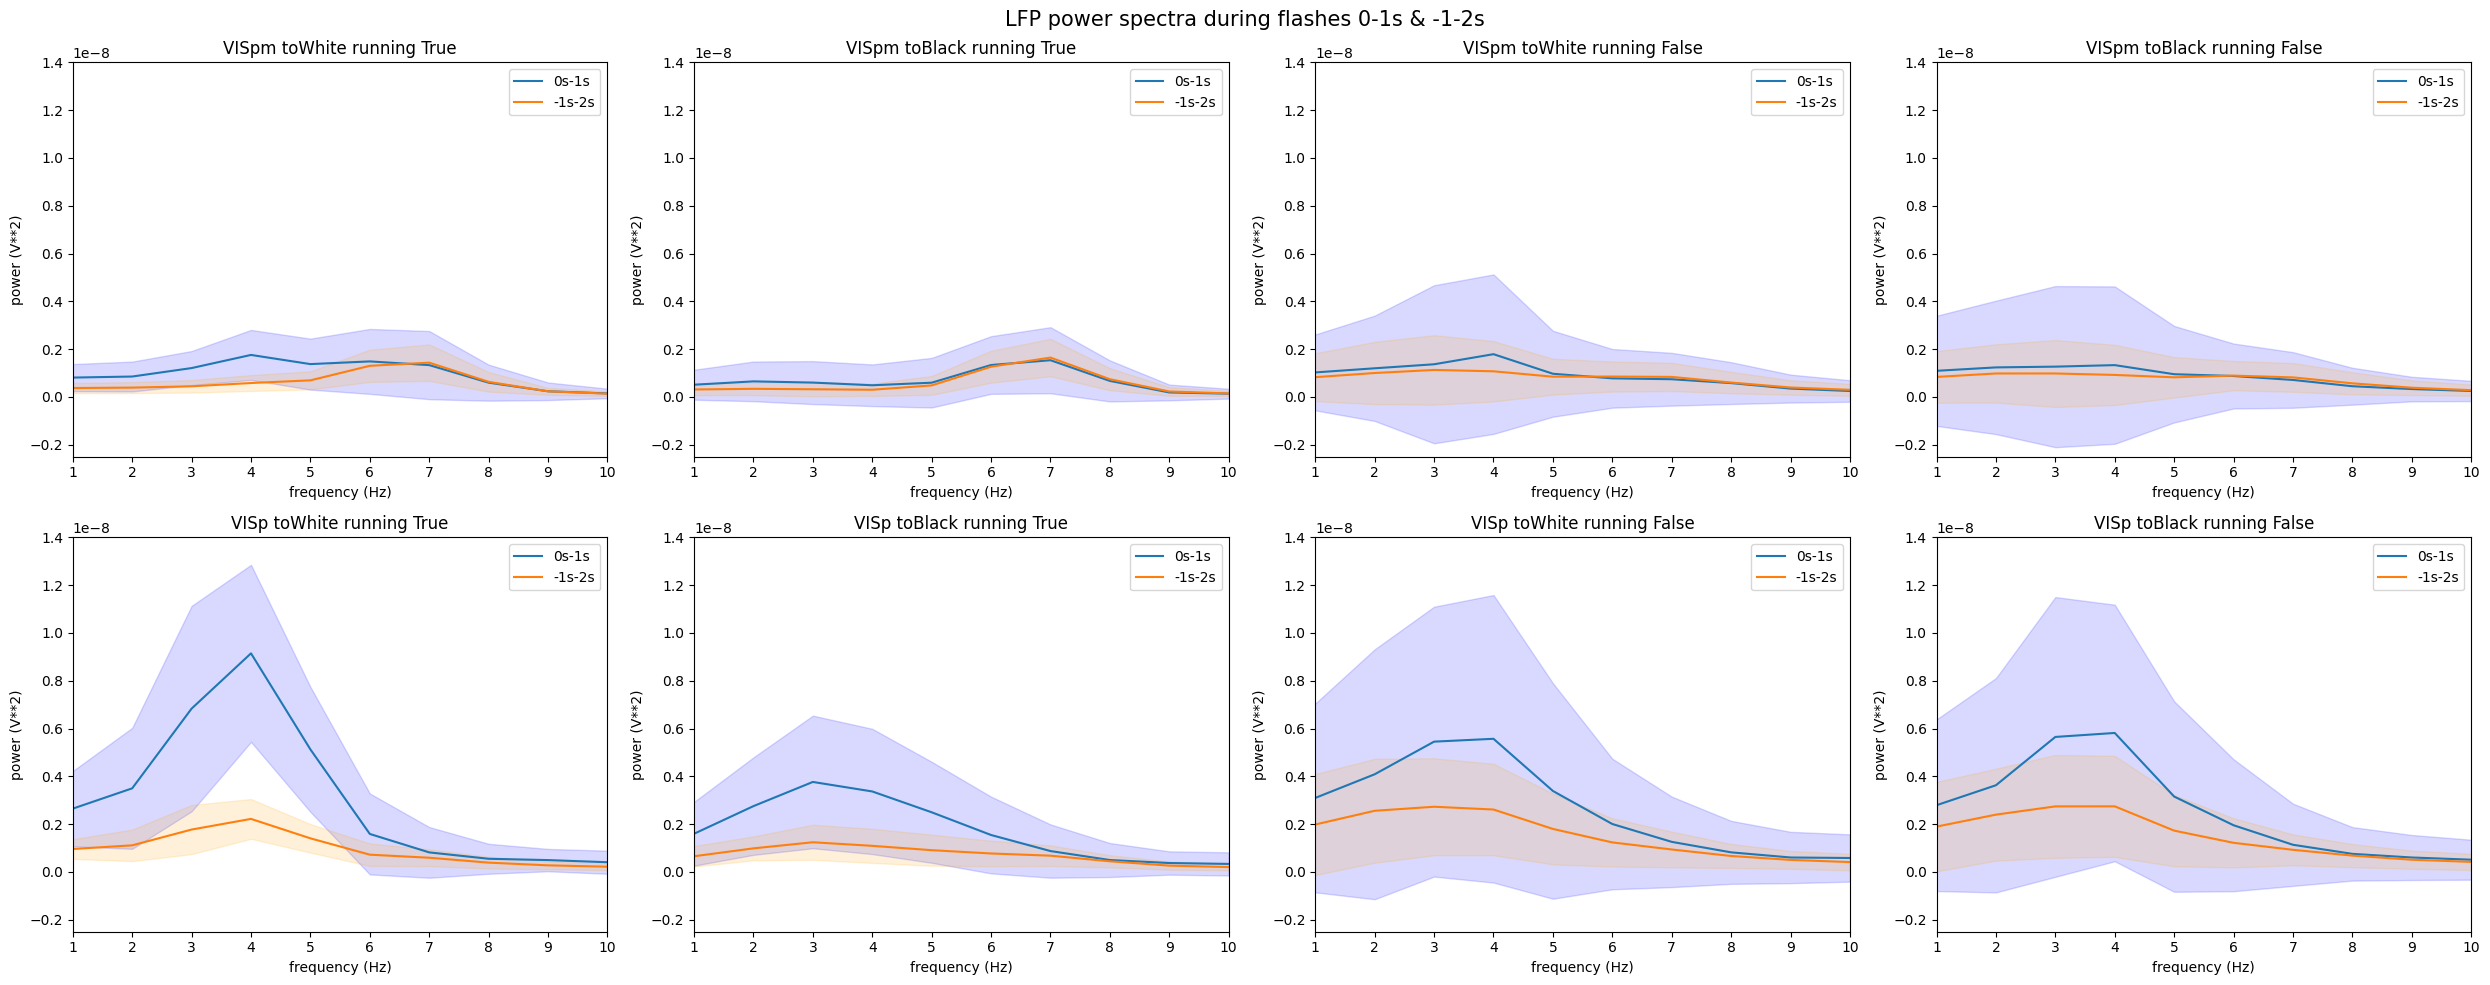

In [77]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(25,10))

fig.suptitle(suptitle,fontsize=15)

for i in range(4):
    
    # ax[0][i].errorbar(f,weighted_average_ps1[i][1] / weighted_average_ps1[i][1].max(), yerr=weighted_average_ps1[i][2] / weighted_average_ps1[i][2].max(),capsize=5)
    # ax[0][i].errorbar(f,weighted_average_ps2[i][1] / weighted_average_ps1[i][1].max(), yerr=weighted_average_ps2[i][2] / weighted_average_ps2[i][2].max(),capsize=5)
    # ax[0][i].errorbar(f, weighted_average_ps1[i][1] / max_power_val, yerr=weighted_average_ps1[i][2] / max_power_val, capsize=5)
    # ax[0][i].errorbar(f, weighted_average_ps2[i][1] / max_power_val, yerr=weighted_average_ps2[i][2] / max_power_val, capsize=5)
    # ax[0][i].errorbar(f, weighted_average_ps1[i][1], yerr=weighted_average_ps1[i][2], capsize=5)
    # ax[0][i].errorbar(f, weighted_average_ps2[i][1], yerr=weighted_average_ps2[i][2], capsize=5)
    ps1 = weighted_average_ps1[i][1]
    upper_ps1 = ps1 + weighted_average_ps1[i][2]
    lower_ps1 = ps1 - weighted_average_ps1[i][2]
    ps2 = weighted_average_ps2[i][1]
    upper_ps2 = ps2 + weighted_average_ps2[i][2]
    lower_ps2 = ps2 - weighted_average_ps2[i][2]
    ax[0][i].plot(f,ps1)
    ax[0][i].fill_between(f,upper_ps1,lower_ps1,color='blue',alpha=0.15)
    ax[0][i].plot(f,ps2)
    ax[0][i].fill_between(f,upper_ps2,lower_ps2,color='orange',alpha=0.15)
    
    ax[0][i].set_title(f'{conditions[i][0]} {conditions[i][1]} running {conditions[i][2]}')
    ax[0][i].legend(legend)
    ax[0][i].set_xlabel('frequency (Hz)')
    ax[0][i].set_ylabel('power (V**2)')
    ax[0][i].set_xlim([1,10])
    ax[0][i].set_ylim(ylims)
    
    # writing delta amplitude values into a dictionary for later numerical comparison
    # ratio is taken between max values of 4-10Hz band (not including 4Hz) to 1-4Hz band (including 4Hz)
    d_ampl_ps1 = ps1[5:].max() / ps1[1:5].max()
    d_ampl_ps2 = ps1[5:].max() / ps1[1:5].max()
    write_to_delta_amplitude_dict(d_ampl_ps1, suptitle, f'area_{conditions[i][0]}_flash_{conditions[i][1]}_running_{conditions[i][2]}_window_{legend[0]}')
    write_to_delta_amplitude_dict(d_ampl_ps1, suptitle, f'area_{conditions[i][0]}_flash_{conditions[i][1]}_running_{conditions[i][2]}_window_{legend[1]}')
    
for i in range(4):
    
    # ax[1][i].errorbar(f,weighted_average_ps1[4+i][1] / weighted_average_ps1[4+i][1].max(), yerr=weighted_average_ps1[4+i][2] / weighted_average_ps1[4+i][2].max(),capsize=5)
    # ax[1][i].errorbar(f,weighted_average_ps2[4+i][1] / weighted_average_ps1[4+i][1].max(), yerr=weighted_average_ps2[4+i][2] / weighted_average_ps2[4+i][2].max(),capsize=5)
    # ax[1][i].errorbar(f, weighted_average_ps1[4+i][1] / max_power_val, yerr=weighted_average_ps1[4+i][2] / max_power_val, capsize=5)
    # ax[1][i].errorbar(f, weighted_average_ps2[4+i][1] / max_power_val, yerr=weighted_average_ps2[4+i][2] / max_power_val, capsize=5)
    # ax[1][i].errorbar(f, weighted_average_ps1[4+i][1], yerr=weighted_average_ps1[4+i][2], capsize=5)
    # ax[1][i].errorbar(f, weighted_average_ps2[4+i][1], yerr=weighted_average_ps2[4+i][2], capsize=5)
    ps1 = weighted_average_ps1[4+i][1]
    upper_ps1 = ps1 + weighted_average_ps1[4+i][2]
    lower_ps1 = ps1 - weighted_average_ps1[4+i][2]
    ps2 = weighted_average_ps2[4+i][1]
    upper_ps2 = ps2 + weighted_average_ps2[4+i][2]
    lower_ps2 = ps2 - weighted_average_ps2[4+i][2]
    ax[1][i].plot(f,ps1)
    ax[1][i].fill_between(f,upper_ps1,lower_ps1,color='blue',alpha=0.15)
    ax[1][i].plot(f,ps2)
    ax[1][i].fill_between(f,upper_ps2,lower_ps2,color='orange',alpha=0.15)
    
    ax[1][i].set_title(f'{conditions[4+i][0]} {conditions[4+i][1]} running {conditions[4+i][2]}')
    ax[1][i].legend(legend)
    ax[1][i].set_xlabel('frequency (Hz)')
    ax[1][i].set_ylabel('power (V**2)')
    ax[1][i].set_xlim([1,10])
    ax[1][i].set_ylim(ylims)
    
    d_ampl_ps1 = ps1[5:].max() / ps1[1:5].max()
    d_ampl_ps2 = ps1[5:].max() / ps1[1:5].max()
    write_to_delta_amplitude_dict(d_ampl_ps1, suptitle, f'area_{conditions[4+i][0]}_flash_{conditions[4+i][1]}_running_{conditions[4+i][2]}_window_{legend[0]}')
    write_to_delta_amplitude_dict(d_ampl_ps1, suptitle, f'area_{conditions[4+i][0]}_flash_{conditions[4+i][1]}_running_{conditions[4+i][2]}_window_{legend[1]}')
    
plt.tight_layout()

plt.savefig(img_save_filename)

plt.show()

# Before flashes & running/non-running LFP power spectra

In [78]:
path = Path.home() / 'Desktop' / 'disk2' / 'lfp_power_spectra_dump_before_flashes'
df_filename = 'lfp_ps_parsed_df_before_flashes.pkl'
weights_column_name = 'segmentsCollected'
suptitle = 'LFP power spectra of spontaneous block before flashes'

In [79]:
conversion_dict = {'sessionID': lambda x: int(x), 'area': lambda x: x, 'running': lambda x: x, 'segmentsCollected': lambda x: int(x), 'micronsElectrodeDepth': lambda x: tryconvert(x.split('.')[0], np.NaN, int), 'filename': lambda x: x}
parsed_df = parse_filenames(path, conversion_dict)
parsed_df

,sessionID,area,running,segmentsCollected,micronsElectrodeDepth,filename
0,797828357,VISpm,False,1,1116.0,sessionID_797828357_area_VISpm_running_False_s...
1,732592105,VISp,True,3,NaN,sessionID_732592105_area_VISp_running_True_seg...
2,754312389,VISp,True,1,1126.0,sessionID_754312389_area_VISp_running_True_seg...
3,778998620,VISp,False,2,946.0,sessionID_778998620_area_VISp_running_False_se...
4,771160300,VISp,False,1,1135.0,sessionID_771160300_area_VISp_running_False_se...
...,...,...,...,...,...,...
111,771160300,VISpm,False,1,816.0,sessionID_771160300_area_VISpm_running_False_s...
112,767871931,VISpm,True,0,1188.0,sessionID_767871931_area_VISpm_running_True_se...
113,778240327,VISpm,False,3,666.0,sessionID_778240327_area_VISpm_running_False_s...
114,742951821,VISpm,True,0,NaN,sessionID_742951821_area_VISpm_running_True_se...


In [80]:
# Deleting rows without segments collected and rows without 4 conditions

for i,cols in parsed_df.iterrows():
    if cols.segmentsCollected == 0:
        parsed_df = parsed_df.drop(parsed_df[parsed_df.sessionID==cols.sessionID].index)

for sid in parsed_df.sessionID.unique():
    if len(parsed_df[parsed_df.sessionID==sid]) != 4:
        parsed_df = parsed_df.drop(parsed_df[parsed_df.sessionID==sid].index)

In [81]:
LOAD = False # the dataframe with computed stats

In [82]:
conditions = [('VISpm', True), ('VISpm', False),
             ('VISp', True), ('VISp', False)]

for condition in conditions:
    selected_df = parsed_df[(parsed_df.area==condition[0]) & (parsed_df.running==condition[1])]
    print(condition, len(selected_df))

('VISpm', True) 19
('VISpm', False) 19
('VISp', True) 19
('VISp', False) 19


In [83]:
parsed_df

,sessionID,area,running,segmentsCollected,micronsElectrodeDepth,filename
1,732592105,VISp,True,3,NaN,sessionID_732592105_area_VISp_running_True_seg...
2,754312389,VISp,True,1,1126.0,sessionID_754312389_area_VISp_running_True_seg...
3,778998620,VISp,False,2,946.0,sessionID_778998620_area_VISp_running_False_se...
5,719161530,VISp,True,10,762.0,sessionID_719161530_area_VISp_running_True_seg...
10,821695405,VISp,False,2,NaN,sessionID_821695405_area_VISp_running_False_se...
...,...,...,...,...,...,...
105,760693773,VISpm,True,2,NaN,sessionID_760693773_area_VISpm_running_True_se...
106,778998620,VISpm,True,1,839.0,sessionID_778998620_area_VISpm_running_True_se...
108,759883607,VISp,True,1,1006.0,sessionID_759883607_area_VISp_running_True_seg...
109,751348571,VISpm,False,20,1214.0,sessionID_751348571_area_VISpm_running_False_s...


## Session averages

In [84]:
parsed_df['f'] = ''
parsed_df['median'] = ''
parsed_df['iqr'] = ''

In [85]:
def filter_out_NaN_ps_elements(s):
    
    collected_i = 0
    collected_ps = []
    for elem in s:
        if not np.isnan(elem.mean()):
            collected_i += 1
            collected_ps.append(elem)
    return collected_i, collected_ps

In [86]:
if LOAD:
    # Load the df
    with open(Path.home() / 'Desktop' / 'disk2' / df_filename, 'rb') as f: parsed_df = pickle.load(f)
else:
    for condition in conditions:
        selected_df = parsed_df[(parsed_df.area==condition[0]) &(parsed_df.running==condition[1])]
        for cols in selected_df.iterrows():
            f, s1, segmentsCollected = np.load(path / cols[1].filename, allow_pickle=True)
            segmentsCollected, s1 = filter_out_NaN_ps_elements(s1)
            parsed_df.at[cols[0], 'segmentsCollected'] = segmentsCollected
            # If NaN filtering removed all segmented from an entry, remove it from the dataframe
            if segmentsCollected == 0: 
                parsed_df = parsed_df.drop(parsed_df[parsed_df.sessionID==cols[1].sessionID].index)
                continue
            s1 = np.array(s1)
            # Saving time data, median time series and iqr (variability measure) time series for eahc condition-session entry
            parsed_df.at[cols[0], 'f'] = f
            parsed_df.at[cols[0], 'median'] = np.median(s1, axis=0)
            parsed_df.at[cols[0], 'iqr'] = get_iqr(s1)

    # Save the df
    with open(Path.home() / 'Desktop' / 'disk2' / df_filename, "wb") as f:
        pickle.dump(parsed_df, f)

In [87]:
parsed_df

,sessionID,area,running,segmentsCollected,micronsElectrodeDepth,filename,f,median,iqr
1,732592105,VISp,True,3,NaN,sessionID_732592105_area_VISp_running_True_seg...,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[4.2148107e-10, 1.4001252e-09, 1.483274e-09, 1...","[3.7255357132615075e-10, 7.514637523353684e-10..."
2,754312389,VISp,True,1,1126.0,sessionID_754312389_area_VISp_running_True_seg...,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[9.7282474e-11, 7.319228e-10, 5.6926364e-10, 3...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,778998620,VISp,False,2,946.0,sessionID_778998620_area_VISp_running_False_se...,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[3.7476028e-10, 2.0256494e-09, 2.2243205e-09, ...","[9.134148992728797e-11, 3.149125404888764e-10,..."
5,719161530,VISp,True,10,762.0,sessionID_719161530_area_VISp_running_True_seg...,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[7.984323e-11, 5.094496e-10, 6.7528905e-10, 6....","[4.421400572052203e-11, 2.641459828645054e-10,..."
10,821695405,VISp,False,2,NaN,sessionID_821695405_area_VISp_running_False_se...,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[3.676458e-10, 1.7660098e-09, 1.0524519e-09, 8...","[2.161711226689178e-10, 6.871164193178458e-10,..."
...,...,...,...,...,...,...,...,...,...
105,760693773,VISpm,True,2,NaN,sessionID_760693773_area_VISpm_running_True_se...,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[3.2073903e-11, 1.8097204e-10, 2.1420823e-10, ...","[7.860375544899156e-12, 3.3154867740137206e-12..."
106,778998620,VISpm,True,1,839.0,sessionID_778998620_area_VISpm_running_True_se...,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[9.352732e-11, 3.857816e-10, 2.9655528e-10, 2....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
108,759883607,VISp,True,1,1006.0,sessionID_759883607_area_VISp_running_True_seg...,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[1.5688449e-10, 2.996374e-10, 3.7265524e-10, 6...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
109,751348571,VISpm,False,20,1214.0,sessionID_751348571_area_VISpm_running_False_s...,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[1.09690285e-10, 5.508829e-10, 7.61747e-10, 7....","[1.1765512262368327e-10, 6.593431980950193e-10..."


## Weighted average of power spectra

In [88]:
weighted_average_ps = []

for condition in conditions:
    selected_df = parsed_df[(parsed_df.area==condition[0]) & (parsed_df.running==condition[1])]
    N = selected_df[weights_column_name].sum()
    
    collected_weighted_median_ps = []
    collected_weighted_iqr_ps = []
    
    for cols in selected_df.iterrows():
        f,ps,ps_iqr = cols[1]['f'],cols[1]['median'],cols[1]['iqr']
        
        collected_weighted_median_ps.append((cols[1][weights_column_name] / N) * ps)
        collected_weighted_iqr_ps.append((cols[1][weights_column_name] / N) * ps_iqr)
        
    collected_weighted_median_ps = np.array(collected_weighted_median_ps)
    collected_weighted_iqr_ps = np.array(collected_weighted_iqr_ps)
        
    weighted_average_ps.append([f, collected_weighted_median_ps.sum(axis=0), collected_weighted_iqr_ps.sum(axis=0)]) 

## Plotting

In [89]:
max_power_val = np.array(weighted_average_ps)[:,1,:].max()
max_power_val

1.5338216252658299e-09

In [90]:
ylims = [0, 2*10**-9]
# ylims = None

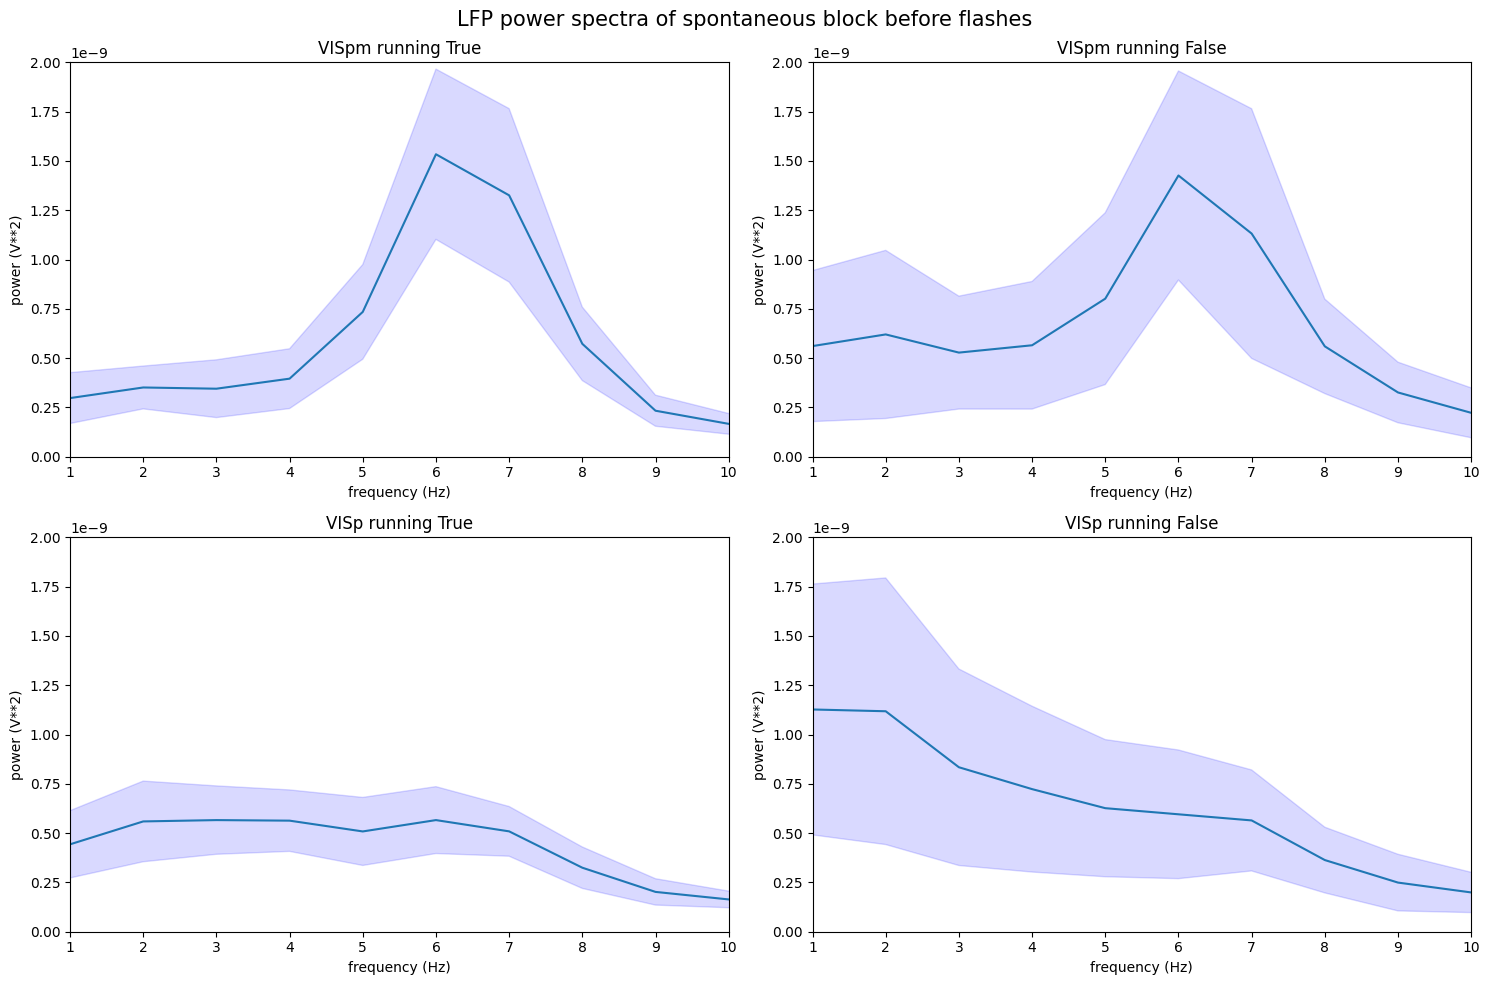

In [91]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

fig.suptitle(suptitle, fontsize=15)

for i in range(2):

    ps = weighted_average_ps[i][1]
    upper_ps = ps + weighted_average_ps[i][2]
    lower_ps = ps - weighted_average_ps[i][2]
    ax[0][i].plot(f,ps)
    ax[0][i].fill_between(f,upper_ps,lower_ps,color='blue',alpha=0.15)
    
    ax[0][i].set_title(f'{conditions[i][0]} running {conditions[i][1]}')
    ax[0][i].set_xlabel('frequency (Hz)')
    ax[0][i].set_ylabel('power (V**2)')
    ax[0][i].set_xlim([1,10])
    ax[0][i].set_ylim(ylims)
    
    d_ampl_ps = ps[5:].max() / ps[1:5].max()
    write_to_delta_amplitude_dict(d_ampl_ps, suptitle, f'area_{conditions[i][0]}_running_{conditions[i][1]}')
    
for i in range(2):

    ps = weighted_average_ps[2+i][1]
    upper_ps = ps + weighted_average_ps[2+i][2]
    lower_ps = ps - weighted_average_ps[2+i][2]
    ax[1][i].plot(f,ps)
    ax[1][i].fill_between(f,upper_ps,lower_ps,color='blue',alpha=0.15)
    
    ax[1][i].set_title(f'{conditions[2+i][0]} running {conditions[2+i][1]}')
    ax[1][i].set_xlabel('frequency (Hz)')
    ax[1][i].set_ylabel('power (V**2)')
    ax[1][i].set_xlim([1,10])
    ax[1][i].set_ylim(ylims)
    
    d_ampl_ps = ps[5:].max() / ps[1:5].max()
    write_to_delta_amplitude_dict(d_ampl_ps, suptitle, f'area_{conditions[2+i][0]}_running_{conditions[2+i][1]}')
    
plt.tight_layout()

plt.savefig('grand_average_lfp_power_spectra_before_flashes.png')

plt.show()

# Save delta amplitude dictionary to a file

In [92]:
with open(Path.home() / 'Desktop' / 'disk2' / 'delta_amplitude_dict.pkl', "wb") as f:
        pickle.dump(delta_amplitude_dict, f)